In [1]:
import os
from pathlib import Path
import requests
from bs4 import BeautifulSoup

import nltk
import numpy as np
import re

import pandas as pd
from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', -1)

sns.set(style="white")

# 1. Missing Data

Files downloaded from Comparative Agendas [https://www.comparativeagendas.net/us], modified from the original Congressional Bills [http://congressionalbills.org/download.html], to use codes that are in line with other datasets on Comparative Agendas. 

As quoted on the website, "All U.S. datasets include two sets of codes: U.S. Policy Agendas codes (PAP) and the international, Comparative Agendas Project codes (CAP).  For analysis across projects and countries, we recommend the CAP codes."

The CAP code master codebook [https://www.comparativeagendas.net/pages/master-codebook] describes the topics and subtopics. 

read the bills data into a dataframe:

In [2]:
bills = pd.read_csv('US-Legislative-congressional_bills_18.1.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7,15,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
bills.shape

(468914, 23)

missing data:

In [4]:
DataFrameSummary(bills).summary().loc['missing_perc']

id                0%    
bill_id           0.04% 
cong              0%    
bill_type         0%    
bill_no           0%    
name_full         0.10% 
description       0%    
intr_date         48.90%
intr_month        48.90%
year              0.04% 
pap_majortopic    0.96% 
pap_subtopic      0.96% 
majortopic        0.96% 
subtopic          0.96% 
filter_plaw       0.00% 
plaw_date         95.99%
plaw_no           59.48%
pass_h            4.44% 
pass_s            2.19% 
majority          1.28% 
party             1.00% 
chamber           0%    
comment           92.76%
Name: missing_perc, dtype: object

topic categories **majortopic**, **subtopic** are the labels, so remove items that are missing **majortopic**

In [5]:
bills.dropna(subset=['majortopic'], inplace=True)

This leaves 1 bill without a **subtopic**:

In [6]:
bills[bills['subtopic'].isna()].description

458410    To amend the Federal Food, Drug, and Cosmetic Act to provide for expedited review of drugs and biological products to provide safer or more effective treatment for males or females, to amend the Public Health Service Act to enhance the consideration of sex differences in basic and clinical research, and for other purposes.
Name: description, dtype: object

label manually using https://www.comparativeagendas.net/pages/master-codebook

In [7]:
bills.loc[458410, 'subtopic'] = 398

In [8]:
DataFrameSummary(bills).summary()

,id,bill_id,cong,bill_type,bill_no,name_full,description,intr_date,intr_month,year,pap_majortopic,pap_subtopic,majortopic,subtopic,filter_plaw,plaw_date,plaw_no,pass_h,pass_s,majority,party,chamber,comment
count,464406,NaN,464406,NaN,464406,NaN,NaN,NaN,235089,464239,464406,464405,464406,464406,464405,NaN,NaN,443579,454137,458389,459700,464406,NaN
mean,253815,NaN,94.5795,NaN,4950.1,NaN,NaN,NaN,5.05867,1974.45,27.3467,2759.16,27.3623,2763.7,0.0541704,NaN,NaN,0.0827068,0.0733105,0.630766,139.751,1.24911,NaN
std,198864,NaN,9.40621,NaN,4434.84,NaN,NaN,NaN,3.18045,66.0565,33.2221,3355.48,33.2138,3353.52,0.226354,NaN,NaN,0.275439,0.260646,0.482598,49.4,0.455701,NaN
min,1,NaN,80,NaN,1,NaN,NaN,NaN,1,0,1,100,1,100,0,NaN,NaN,0,0,0,100,0,NaN
25%,116104,NaN,87,NaN,1660,NaN,NaN,NaN,2,1962,8,800,8,802,0,NaN,NaN,0,0,0,100,1,NaN
50%,232206,NaN,93,NaN,3423,NaN,NaN,NaN,5,1973,16,1608,16,1608,0,NaN,NaN,0,0,1,100,1,NaN
75%,340832,NaN,102,NaN,7019,NaN,NaN,NaN,7,1991,21,2101,21,2101,0,NaN,NaN,0,0,1,200,2,NaN
max,1.00891e+06,NaN,114,NaN,20587,NaN,NaN,NaN,12,2016,99,9999,99,9999,1,NaN,NaN,1,1,1,400,2,NaN
counts,464406,464240,464406,464406,464406,463922,464406,235089,235089,464239,464406,464405,464406,464406,464405,18799,189917,443579,454137,458389,459700,464406,29428
uniques,456912,464234,35,4,20587,5238,315583,7216,12,71,21,230,22,225,2,2836,8789,2,2,2,7,3,4


In [9]:
bills.head(2)

,id,bill_id,cong,bill_type,bill_no,name_full,description,intr_date,intr_month,year,pap_majortopic,pap_subtopic,majortopic,subtopic,filter_plaw,plaw_date,plaw_no,pass_h,pass_s,majority,party,chamber,comment
0,38921,80-HR-705,80,HR,705,"Church, Ralph E.",For the relief of David Cowan,NaN,NaN,1947.0,99.0,9999.0,99.0,9999.0,0.0,NaN,NaN,0.0,0.0,1.0,200.0,1,NaN
1,43463,80-HR-5258,80,HR,5258,"Regan, Kenneth M.",For the relief of Mrs. Mary Chagra,NaN,NaN,1948.0,99.0,9999.0,99.0,9999.0,0.0,NaN,NaN,0.0,0.0,0.0,100.0,1,NaN


missing data in other columns:
- Some **bill_id** are missing. **cong**, **bill_type**, and **bill_no** contain the same information, and don't have missing data, so these could be used to reconstruct bill_id if want them (for reference) later
- Some **year** are missing. Many of these are from $2012$ (not shown) as indicated by **intr_date** and could be filled in if needed later

The most important columns are:
- **description**: the title of the bill
- **majortopic**: 1 of 22 major topics
- **subtopic**: 1 of 225 minor topics

For now focus on **description**, **majortopic** and **subtopic**, though additional columns may help with bill labeling (e.g. which party, whether the bill was passed).

In [10]:
cols = ['description', 'majortopic', 'subtopic']

bills['majortopic'] = bills['majortopic'].astype(int)
bills['subtopic'] = bills['subtopic'].astype(int)
bills = bills[cols]

# 2. Exploratory Data Analysis

## 2.1 Raw data

### 2.1.1 majortopic

In [11]:
sorted(bills['majortopic'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 99]

These correspond to the master codebook https://www.comparativeagendas.net/pages/master-codebook, except 99:

In [12]:
bills99 = bills[bills['majortopic'] == 99]
display(bills99.description.head())

0     For the relief of David Cowan                             
1     For the relief of Mrs. Mary Chagra                        
2     For the relief of Edgar D. Sebring and Jay Purple         
6     For the relief of Charles W. Taylor, Jr                   
10    For the relief of Graphic Arts Corp., of Ohio Toledo, Ohio
Name: description, dtype: object

In [13]:
not_relief_bills99 = bills99[~bills99['description'].str.contains('relief', case=False)]
len(not_relief_bills99), len(bills99)

(1756, 79952)

Most bills with label 99 are relief bills, but there are 1756 that are not. Here are the first 10:

In [14]:
not_relief_bills99.description.head(10)

16      A bill to authorize the awarding of medals to certain war correspondents                                                                                           
288     To provide for the advancement of James Edgar Davis on the emergency officers retired list of the Army                                                             
298     A bill to transfer the Remount Service from the War Department to the Department of Agriculture                                                                    
336     To provide for the admission of Lawrence M. Lew to the United States as a nonquota immigrant                                                                       
404     To record the lawful admission to the United States for permanent residence. of Tadeusz Glogowski, Maria L. Glogowska, Leokadia Glogowska, and Malgorzata Glogowska
501     To authorize the cancellation of deportation proceedings in the case of Ancieto Zacevich or Anciento Zacevich or Ernest Zacevich    

Some mixed topics, though many about admission / deportation to US. Drop these as outside main categories

In [15]:
bills = bills[bills['majortopic'] != 99]

record topics in a ditionary

In [16]:
dict_number_topic = {1: 'Macroeconomics',
                     2: 'Civil Rights',
                     3: 'Health',
                     4: 'Agriculture',
                     5: 'Labor',
                     6: 'Education',
                     7: 'Environment',
                     8: 'Energy',
                     9: 'Immigration',
                     10: 'Transportation',
                     12: 'Law and Crime',
                     13: 'Social Welfare',
                     14: 'Housing',
                     15: 'Domestic Commerce',
                     16: 'Defense',
                     17: 'Technology',
                     18: 'Foreign Trade',
                     19: 'International Affairs',
                     20: 'Government Operations',
                     21: 'Public Lands',
                     23: 'Culture'
                    }

### bill counts by topic

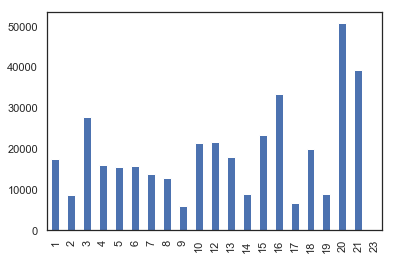

In [17]:
bills['majortopic'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [18]:
bills['majortopic'].value_counts().loc[23]

53

Not too unbalanced, except for topic label 23 (cultural bills), which has only 53 bills. So these might be difficult to classify

## 2.1.2 subtopic

counts of subtopics is much less balanced so will be harder to classify:

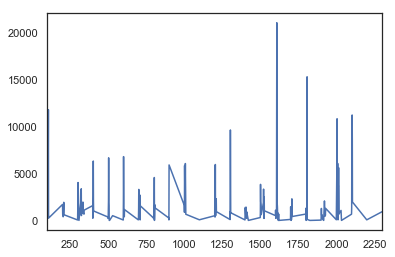

In [19]:
subtopic_count = bills['subtopic'].value_counts().sort_index()
subtopic_count.plot()
plt.show()

In [20]:
subtopic_count.median()

848.0

With half the subtopics having more than 848 bills, still have potential to look at the more common subtopics.

## 2.1.3 bill titles

In [21]:
bills['description_length'] = bills['description'].str.len()
bills['description_nwords'] = bills['description'].str.split().str.len()

bills with short titles:

In [22]:
bills[bills['description_length']<20]

,description,majortopic,subtopic,description_length,description_nwords
7064,To decontrol sugar,4,402,18,3
26919,To raise revenue,10,1002,16,3
82153,For sailors.,16,1608,12,2
100907,x,20,2003,1,1
197292,Water Bank Act,10,1007,14,3
199024,Water Bank Act,10,1007,14,3
209431,Fish cancer study,4,405,17,3
228256,To end the war,16,1619,14,4
261650,Postal Reform Act,20,2003,17,3
273116,Bentsen,9,900,7,1


Can see several acronyms - fairly extensive list here https://noahveltman.com/acronyms/#words?word=EACH

distribution of number of words:

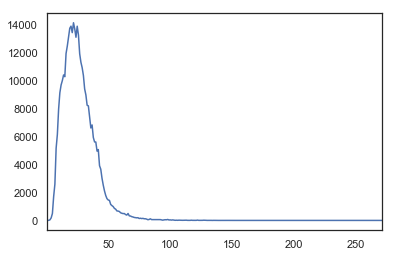

In [23]:
nwords_counts = bills['description_nwords'].value_counts().sort_index()
nwords_counts.plot()
plt.show()

long tail - variable length of bill titles may be tricky for some models

# 2.2 Prepare for model - tokenize

In [107]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def tokenize_doc(doc, complete=False):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    if complete:
        return tokens
    else:
        filtered_tokens = [token for token in tokens if token not in stop_words]
        return filtered_tokens

bills['tokens'] = bills['description'].apply(tokenize_doc)
bills['tokens_complete'] = bills['description'].apply(tokenize_doc, complete=True)

In [25]:
# re-create decription from filtered tokens
bills['norm_description'] = bills['tokens'].str.join(' ')

In [26]:
bills.head(3)

,description,majortopic,subtopic,description_length,description_nwords,tokens,norm_description
3,To increase the rates of certain educational and readjustment allowances payable to veterans in order to compensate for the higher cost of living in Alaska,6,601,155,25,"[increase, rates, certain, educational, readjustment, allowances, payable, veterans, order, compensate, higher, cost, living, alaska]",increase rates certain educational readjustment allowances payable veterans order compensate higher cost living alaska
4,To encourage enterprise capital investment in private business and aid industrial preparedness for national emergencies by abolishing mandatory depreciation deductions in loss years and permitting reduced depreciation deductions in low income years for Fe,1,100,255,34,"[encourage, enterprise, capital, investment, private, business, aid, industrial, preparedness, national, emergencies, abolishing, mandatory, depreciation, deductions, loss, years, permitting, reduced, depreciation, deductions, low, income, years, fe]",encourage enterprise capital investment private business aid industrial preparedness national emergencies abolishing mandatory depreciation deductions loss years permitting reduced depreciation deductions low income years fe
5,"To continue rent control until June 30, 1950, and for other purposes",14,1406,68,12,"[continue, rent, control, june, purposes]",continue rent control june purposes


In [27]:
all_words = [word for tokens in bills["tokens"] for word in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

5689187 words total, with a vocabulary size of 49980


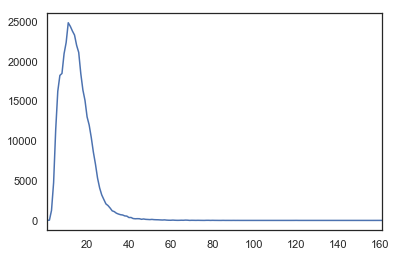

In [28]:
bills['description_ntokens'] = bills['tokens'].str.len()
ntokens_counts = bills['description_ntokens'].value_counts().sort_index()
ntokens_counts.plot()
plt.show()

# 3. Modeling

## 3.1 bag of words for baseline

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

train test split:

In [92]:
list_corpus = bills["norm_description"].tolist()
list_labels = bills["majortopic"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=42)

bag of words embedding:

In [31]:
def cv(data):
    count_vectorizer = CountVectorizer()

    embedding = count_vectorizer.fit_transform(data)

    return embedding, count_vectorizer

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [32]:
X_train_counts.shape, X_test_counts.shape

((307563, 45933), (76891, 45933))

In [33]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)

In [34]:
sgd_clf.fit(X_train_counts, y_train)
sgd_clf.coef_.shape

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(21, 45933)

In [55]:
y_test_predicted = sgd_clf.predict(X_test_counts)
accuracy_score(y_test_predicted, y_test)

0.8374061983847264

compute accuracy for each major topic:

In [54]:
cm = confusion_matrix(y_test, y_test_predicted)
accuracy_topic = np.diag(cm / cm.sum(axis=1, keepdims=True))
accuracy_topic

array([0.73923304, 0.70858164, 0.89152481, 0.85923845, 0.79305913,
       0.86530612, 0.79407352, 0.86904762, 0.88508772, 0.85973905,
       0.80215912, 0.82460586, 0.75644542, 0.78263638, 0.85976977,
       0.79105572, 0.90722681, 0.71651786, 0.84377793, 0.90195577,
       0.53333333])

In [37]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {index:word for word,index in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        class_label = model.classes_[class_index]
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        top = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[dict_number_topic[class_label]] = {
            'top':top,
            'bottom':bottom
        }
    return classes

In [64]:
importance = get_most_important_features(count_vectorizer, sgd_clf, 5)

In [65]:
for key, value in importance.items():
    print(key)
    print([el_word[1] for el_word in value['top']])
    print([el_word[1] for el_word in value['bottom']])
    print('')

Macroeconomics
['inflation', 'budget', 'stabilization', 'charitable', 'debt']
['mortgage', 'farm', 'communications', 'gasoline', 'small']

Civil Rights
['discrimination', 'privacy', 'abortion', 'abortions', 'subversive']
['countries', 'international', 'children', 'registering', 'revenue']

Health
['medicare', 'optometry', 'alcoholism', 'nursing', 'supplements']
['designate', 'unemployed', 'native', 'indians', 'indian']

Agriculture
['fishery', 'wheat', 'sugar', 'crop', 'agricultural']
['children', 'stamp', 'home', 'labor', 'workers']

Labor
['unemployed', 'labormanagement', 'unemployment', 'labor', 'occupational']
['columbia', 'discrimination', 'railway', 'veterans', 'civil']

Education
['library', 'learning', 'arts', 'education', 'tuition']
['lunch', 'medical', 'health', 'columbia', 'indian']

Environment
['wetlands', 'erosion', 'environmental', 'clean', 'pollution']
['aviation', 'merchant', 'fishery', 'flood', 'energy']

Energy
['petroleum', 'electrification', 'gas', 'hydroelectric',

## 3.2 TF-IDF Bag of Words

In [85]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    embedding = tfidf_vectorizer.fit_transform(data)

    return embedding, tfidf_vectorizer

X_train_counts_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_counts_tfidf = tfidf_vectorizer.transform(X_test)

In [86]:
sgd_clf_tfidf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf_tfidf.fit(X_train_counts_tfidf, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
y_test_predicted_tfidf = sgd_clf_tfidf.predict(X_test_counts_tfidf)
accuracy_score(y_test_predicted_tfidf, y_test)

0.8138273660116269

slightly worse!

compute accuracy for each major topic:

In [88]:
cm_tfidf = confusion_matrix(y_test, y_test_predicted_tfidf)
accuracy_topic_tfidf = np.diag(cm_tfidf / cm_tfidf.sum(axis=1, keepdims=True))

array([0.68761062, 0.57747318, 0.86762043, 0.83302122, 0.78020566,
       0.85274725, 0.76031508, 0.85215054, 0.86315789, 0.84133271,
       0.78995541, 0.81897523, 0.72682392, 0.73997028, 0.86126476,
       0.76392962, 0.90172543, 0.59207589, 0.81676433, 0.90131663,
       0.        ])

compare tf-idf accuracy to baseline:

In [90]:
print('topic (bag of words accuracy, bag of words tf-idf accuracy)\n')

for i, item in enumerate(zip(accuracy_topic, accuracy_topic_tfidf)):
    print(dict_number_topic[sgd_clf.classes_[i]], item)

topic (bag of words accuracy, bag of words tf-idf accuracy)

Macroeconomics (0.7392330383480826, 0.6876106194690266)
Civil Rights (0.7085816448152562, 0.5774731823599524)
Health (0.8915248098515031, 0.8676204273813836)
Agriculture (0.8592384519350812, 0.8330212234706617)
Labor (0.7930591259640103, 0.7802056555269923)
Education (0.8653061224489796, 0.8527472527472527)
Environment (0.794073518379595, 0.7603150787696924)
Energy (0.8690476190476191, 0.8521505376344086)
Immigration (0.8850877192982456, 0.8631578947368421)
Transportation (0.8597390493942219, 0.8413327120223671)
Law and Crime (0.8021591175780334, 0.7899554095282797)
Social Welfare (0.8246058558558559, 0.8189752252252253)
Housing (0.7564454196379594, 0.7268239166209545)
Domestic Commerce (0.7826363829335597, 0.7399702823179792)
Defense (0.8597697712662581, 0.8612647630438033)
Technology (0.7910557184750733, 0.7639296187683284)
Foreign Trade (0.9072268067016754, 0.9017254313578394)
International Affairs (0.7165178571428571, 0.5

compare most importance words to baseline:

In [91]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, sgd_clf_tfidf, 5)

for k, v1, v2 in zip(importance.keys(), importance.values(), importance_tfidf.values()):
    print(k)
    print([el_word[1] for el_word in v1['top']])
    print([el_word[1] for el_word in v2['top']])
    print('')

Macroeconomics
['inflation', 'budget', 'stabilization', 'charitable', 'debt']
['inflation', 'charitable', 'estate', 'debt', 'budget']

Civil Rights
['discrimination', 'privacy', 'abortion', 'abortions', 'subversive']
['rights', 'voting', 'desecration', 'privacy', 'discrimination']

Health
['medicare', 'optometry', 'alcoholism', 'nursing', 'supplements']
['hospital', 'xviii', 'medical', 'medicare', 'health']

Agriculture
['fishery', 'wheat', 'sugar', 'crop', 'agricultural']
['meat', 'sugar', 'crop', 'farm', 'agricultural']

Labor
['unemployed', 'labormanagement', 'unemployment', 'labor', 'occupational']
['mine', 'pension', 'occupational', 'unemployment', 'labor']

Education
['library', 'learning', 'arts', 'education', 'tuition']
['higher', 'student', 'arts', 'educational', 'education']

Environment
['wetlands', 'erosion', 'environmental', 'clean', 'pollution']
['wildlife', 'waste', 'clean', 'environmental', 'pollution']

Energy
['petroleum', 'electrification', 'gas', 'hydroelectric', 'e

understanding poorer performance of tf-idf...

1. We already removed stop words, so there is less need for tf-idf

2. Looking at international affairs, many bills might contain the words 'israel' or 'cuba', which indicate bills about international affairs. In which case, underweighting 'israel' / 'cuba' leads to poorer model performance.

## 3.3 word2vec with average of embeddings

In [223]:
from path import Path

In [224]:
with open('path_saved_word2vec.txt') as f:
    path = Path(f.readline())
    f.close

In [226]:
import gensim

word2vec_path = path / "GoogleNews-vectors-negative300.bin.gz"
# word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [116]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, bills, generate_missing=False):
    embeddings = bills['tokens'].apply(lambda x: get_average_word2vec(x,
                                                                      vectors, 
                                                                      generate_missing=generate_missing
                                                                     )
                                      )
    return list(embeddings)

In [117]:
embeddings = get_word2vec_embeddings(word2vec, bills)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(embeddings, list_labels, 
                                                                    test_size=0.2, random_state=42)

In [118]:
sgd_clf_w2v = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf_w2v.fit(X_train_w2v, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [119]:
y_test_predicted_w2v = sgd_clf_w2v.predict(X_test_w2v)
accuracy_score(y_test_predicted_w2v, y_test)

0.7498016672952621

compute accuracy for each major topic:

In [120]:
cm_w2v = confusion_matrix(y_test, y_test_predicted_w2v)
accuracy_topic_w2v = np.diag(cm_w2v / cm_w2v.sum(axis=1, keepdims=True))

compare tf-idf accuracy to baseline:

In [121]:
print('topic (bag of words accuracy, bag of words tf-idf accuracy)\n')

for i, item in enumerate(zip(accuracy_topic, accuracy_topic_w2v)):
    print(dict_number_topic[sgd_clf.classes_[i]], item)

topic (bag of words accuracy, bag of words tf-idf accuracy)

Macroeconomics (0.7392330383480826, 0.5926253687315635)
Civil Rights (0.7085816448152562, 0.46781883194278906)
Health (0.8915248098515031, 0.8658094893154654)
Agriculture (0.8592384519350812, 0.8167915106117354)
Labor (0.7930591259640103, 0.6860539845758354)
Education (0.8653061224489796, 0.796232339089482)
Environment (0.794073518379595, 0.6676669167291823)
Energy (0.8690476190476191, 0.8287250384024577)
Immigration (0.8850877192982456, 0.85)
Transportation (0.8597390493942219, 0.7958993476234856)
Law and Crime (0.8021591175780334, 0.7176719080028162)
Social Welfare (0.8246058558558559, 0.7173423423423423)
Housing (0.7564454196379594, 0.6604498080087767)
Domestic Commerce (0.7826363829335597, 0.6639779240076417)
Defense (0.8597697712662581, 0.7712662580355808)
Technology (0.7910557184750733, 0.7016129032258065)
Foreign Trade (0.9072268067016754, 0.8617154288572143)
International Affairs (0.7165178571428571, 0.493303571428571

## 3.4 CNN - first steps

(https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [149]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [150]:
all_words_complete = [word for tokens in bills["tokens_complete"] for word in tokens]
VOCAB_COMPLETE = sorted(list(set(all_words_complete)))
sentence_lengths = [len(tokens) for tokens in bills["tokens_complete"]]
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB_COMPLETE)))
print("Max sentence length is %s" % max(sentence_lengths))

5689187 words total, with a vocabulary size of 50110
Max sentence length is 263


In [151]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 264
VOCAB_SIZE = len(VOCAB_COMPLETE)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(bills["description"].tolist())
sequences = tokenizer.texts_to_sequences(bills["description"].tolist())

In [152]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49625 unique tokens.


In [153]:
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(bills["majortopic"]))
print('Shape of data tensor:', cnn_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (384454, 264)
Shape of label tensor: (384454, 24)


In [208]:
labels_index = labels.shape[1]
labels_index

24

In [209]:
indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

# rows of embedding_weights are vector embedding for each of the words in word_index
embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

(49626, 300)


In [210]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

In [211]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_weights],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [214]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
print(sequence_input)

Tensor("input_19:0", shape=(?, 264), dtype=int32)


In [215]:
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(labels_index, activation='softmax')(x)

In [216]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [217]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [219]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Train on 307564 samples, validate on 76890 samples
Epoch 1/3
307564/307564 [==============================] - 691s 2ms/step - loss: 2.1305 - acc: 0.3769 - val_loss: 1.8560 - val_acc: 0.4679
Epoch 2/3
307564/307564 [==============================] - 683s 2ms/step - loss: 1.7518 - acc: 0.4961 - val_loss: 1.7305 - val_acc: 0.5033
Epoch 3/3
307564/307564 [==============================] - 686s 2ms/step - loss: 1.6327 - acc: 0.5285 - val_loss: 1.6816 - val_acc: 0.5163


converging rather slowly, presumably because of all the padding for max sentence length of 263